## Taxi driving with DQN

In [3]:
import gym
import numpy as np
import torch
from torch import nn
from PIL import Image
import random
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output
from time import sleep

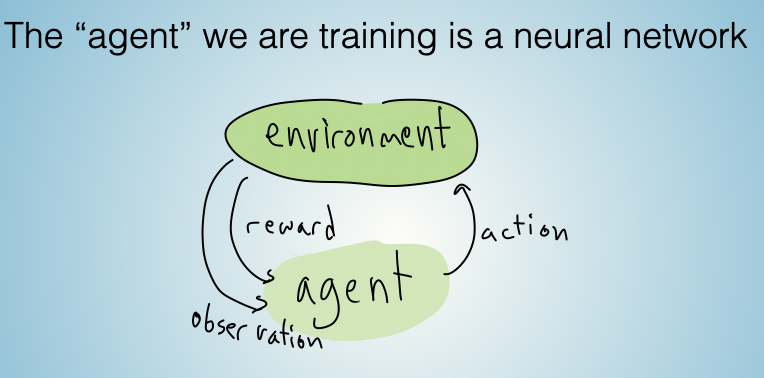

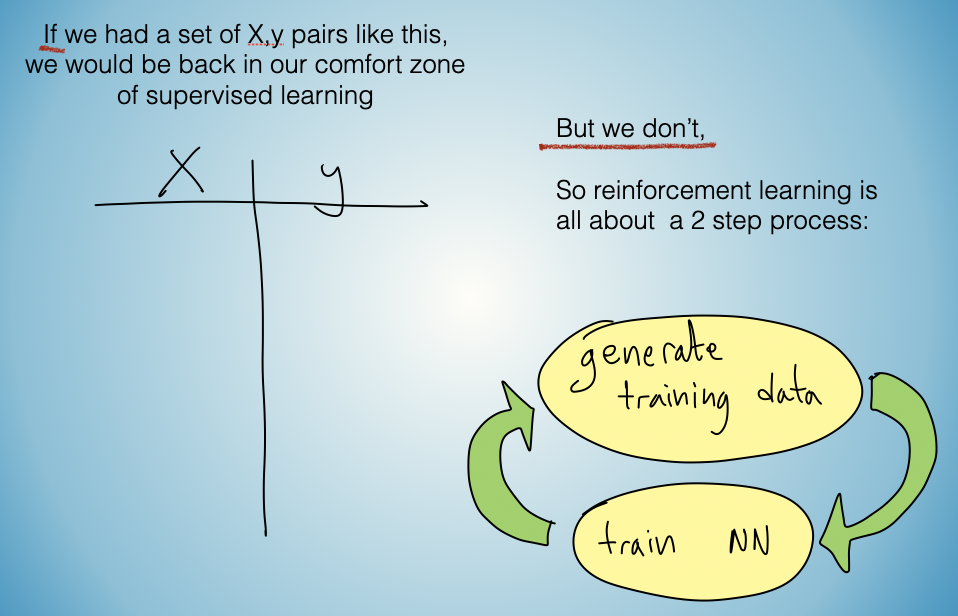

## the task: taxi-v3 from openai gym

this task involves driving a taxi on a 5x5 grid to pick up a passanger from 1 location and drop him off at a destination

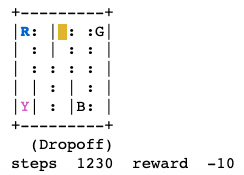

In [4]:
env = gym.make('Taxi-v3').env
env.reset();

there are 6 possible actions, south/north/east/west/pickup/dropoff

there is a more detailed explanation of the game here: 
https://learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
where also you will find a detailed description of the "non-neural-net based" solution

In [5]:
env.action_space

Discrete(6)

## Let's see a random game being played, where the actions is chosen randomly

notice that the environment gives -1 reward for each time step where you don't finish the task, -10 reward for incorrect dropoff/pickup and +20 points for finishing the task.

the random agent can take a long time to finish the task - if you see this game being played for more than 1000+ steps, feel free to kill it and try again. sometimes it mananges to finish in under 1000 steps.

In [21]:
def play_game(render=False):
    done = False
    steps = 0
    state = env.reset()
    while not done:
        steps+=1
        clear_output(wait=True)
        next_state, reward , done, env_info = env.step( env.action_space.sample() )
        if render:
            env.render()
            print('steps ',steps,' reward ',reward)

        if done:
            if render:
                print('done!')
            return steps
        else:
            state = next_state
        
    return -99
    

play_game(render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
steps  1376  reward  20
done!


1376

## we can train an agent to "solve" this task in about 30 seconds using Q-learning (no neural network). This is because there are only 500 possible states in the game

5x5 position of the taxi, 5 possible passanger locations, 4 possible destinations

we solve the game by creating a 500x6 matrix, where each state in the game (described by an integer between 0 and 499) has a quality value to each possible action. the max value determines which action we will take.

we start with all 0 "Q values" and start playing games randomly, updating the q values based on the rewards we observe, a quick but clear description of this algorithm you can read here:
https://learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

this algorithm learns to solve the task well in about 30 seconds of "training"

In [7]:
#start with the all zeros table,
q_table = np.zeros([env.observation_space.n, env.action_space.n])

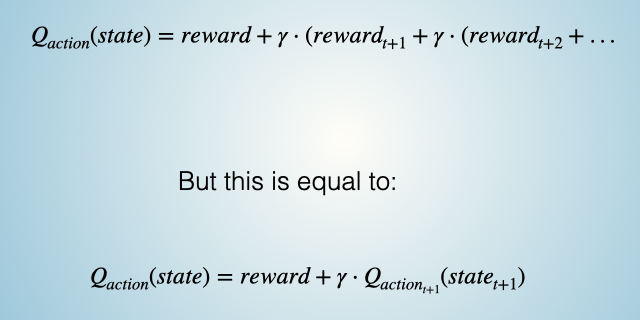

In [8]:
#training parameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

In [9]:
steps_per_game = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    steps = 0
    
    while not done:
        steps+=1
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        state = next_state
        
        if done:
            steps_per_game.append(steps)
            
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

Episode: 100000


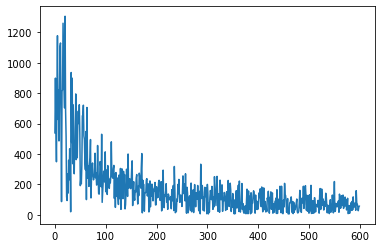

In [10]:
#we can see that over the first 100 games the number of steps it takes to finish the game dropped dramatically

plt.plot(steps_per_game[:600])

### Once trained, we can see our q-table agent play the game almost perfectly

In [22]:
def play_game(render=False):
    done = False
    steps = 0
    state = env.reset()
    while not done:
        steps+=1
        clear_output(wait=True)
        next_state, reward , done, env_info = env.step( np.argmax(q_table[state] ) )
        if render:
            env.render()
            print('steps ',steps)

        if done:
            if render:
                print('done!')
                sleep(1)
            return steps
        else:
            state = next_state
        if render:
            sleep(0.1)
    
    
for game_i in range(5):
    play_game(render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
steps  11
done!


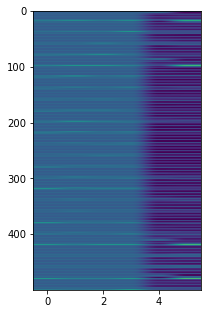

In [14]:
fig,ax = plt.subplots(figsize=(3,8))

ax.imshow(q_table)
ax.set_aspect(0.02)

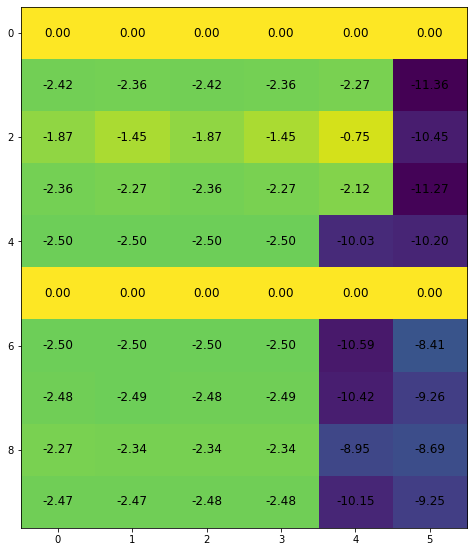

In [25]:
fig,ax = plt.subplots(figsize=(8,12))

ax.imshow(q_table[:10])
ax.set_aspect(0.7)

for (j,i),label in np.ndenumerate(q_table[:10]):
    ax.text(i,j,'{0:.2f}'.format(label),ha='center',va='center',fontsize=12)

In [24]:
np.argmax(q_table[1] )

4

## the problem is that with more complicated environments, we don't have such a small number (500) of possible states. so the q-table is replaced with a neural network

below we define the neural network, which take in a state (an integer between 0 and 499) and outputs 6 "q-values" for the 6 possible actions

In [12]:
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Embedding(500,20),
        nn.Linear(20,50),nn.ReLU(),
        nn.Linear(50,50),nn.ReLU(),
        nn.Linear(50,6))

    def forward(self, x):
        
        return self.layers(x)

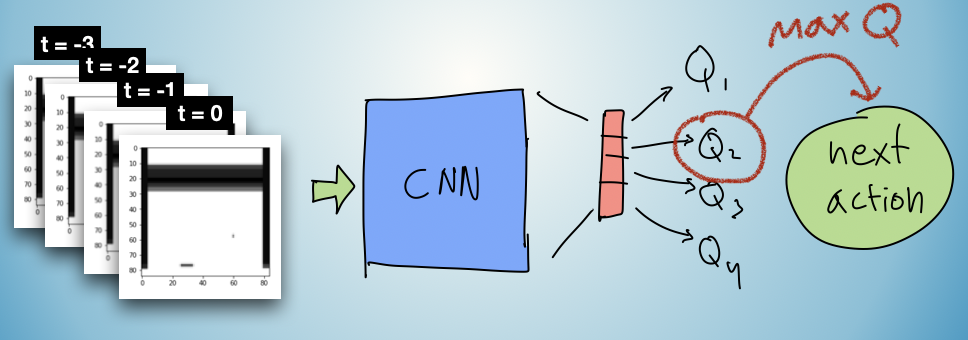



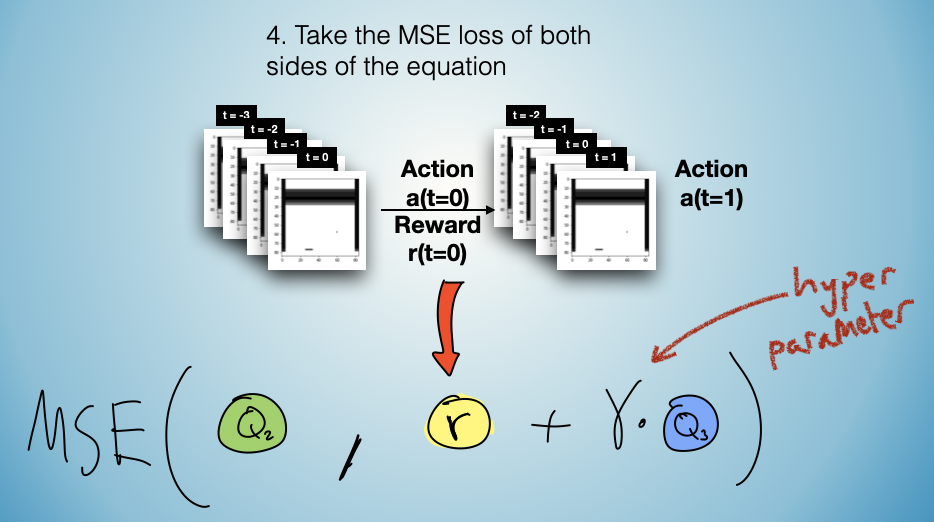

## define a function to choose an action based on neural network output and epsilon parameter

notice I divide the reward by 20, to put it in the range between -1,1

In [13]:
def ChooseAction(env,net,state,eps):
        
    if random.uniform(0, 1) < eps:
        action = env.action_space.sample()
    else:   
        q, arg_q = net(torch.LongTensor([state])).data.cpu().max(1) # choose max Q and matching action
        action = arg_q.item()
    
    next_state, reward, done, _ = env.step(action)
    
    
    reward = reward/20.0
    
    return next_state, reward, action, done

## now we define a function to play a single game with our neural network agent, and save the memory of (state, action, reward, next state) transitions

note: this algorithm is much less efficient compared to the non-neural-net algorithm shown above, in order for the results to be seen quickly, we use

state = env.encode(0, 0, 3, 2)

at the start of the game.
this tell the game to always start the taxi in the same position, and to always pick up and dropoff the passanger and the same pickup/dropoff locations. this simplifies things so we can train in a few minutes

so the taxi starts at R, has to go to B, pickup, go to Y, and dropoff


In [23]:
def play_game_agent(agent,eps,render=False):
    done = False
    steps = 0
    state = env.reset()
    state = env.encode(0, 0, 3, 2)
    env.s = state
    
    single_game_memory = []
    game_total_reward = 0
    
    while not done and steps < 1000: #limit the number of steps a game can go on for
        steps+=1
        if render:
            clear_output(wait=True)
        
        next_state, reward , action, done  = ChooseAction(env,agent,state,eps=eps) 
        
        game_total_reward+=reward
        single_game_memory.append((torch.LongTensor([state]),torch.LongTensor([int(action)]),
                                  torch.Tensor([reward]),torch.LongTensor([next_state]),torch.Tensor([done]) ))
        
        if render:
            env.render()
            print('steps ',steps,'action ',action ,' reward ',reward)
        

        if done:
            if render:
                print('done!')
            
        else:
            state = next_state
        if render and steps < 20:
            sleep(0.1)
    return single_game_memory,steps,game_total_reward

qnet = QNet()
qnet.eval()
play_game_agent(qnet,1,render=True);

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
steps  1000 action  1  reward  -0.05


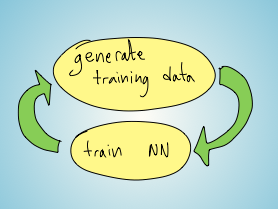

## we store the (state,action,reward, next state) information in a memory buffer

let's define the class for that memory buffer.

notice that I stored transitions with positive rewards in a different buffer, and when sampling from memory, I pick at least 1/4 of the mini-batch to have positive rewards samples. this is a simplified version of many techniques that use some variation on the sampling strategy to help DQN algorithms train faster

In [15]:
class ReplayMemory(object):
    """ Facilitates memory replay. """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory_neg = []
        self.memory_pos = []

    def push(self, m):
        
        positive_m = [x for x in m if x[2].item() > 0]
        negative_m = [x for x in m if  x[2].item() <= 0]
        
        #add new memory to storage
        self.memory_neg += negative_m 
        self.memory_pos += positive_m
        
        
        #if our memory is over the max size, discard the first elements
        if len(self.memory_neg) > self.capacity:
            self.memory_neg = self.memory_neg[-self.capacity:]
        if len(self.memory_pos) > self.capacity:
            self.memory_pos = self.memory_pos[-self.capacity:]
        
    def sample(self, bsz):
        
        pos_batch_size = int( min(bsz/4,len(self.memory_pos)) )
        
        if pos_batch_size > 0:
            pos_batch = random.sample(self.memory_pos, pos_batch_size)
        else:
            pos_batch = []
            
        neg_batch = random.sample(self.memory_neg, bsz-pos_batch_size)
        
        batch = pos_batch+neg_batch
        
        return map(lambda x: torch.cat(x, 0), zip(*batch))

## now we are ready to start training our agent

remember the cycle is this:
1. genenrate some games with the existing network, but inject some randomness with the epsilon parameter

epsilon parameter decays to give more control to neural network as training progresses

2. save the transitions in memory while playing
3. start a training cycle, sample a mini-batch from memory, train the neural network

In [75]:
### hyperparameters

max_episodes = 120
n_games_per_episode = 20
n_train_steps = 3000 #per episode

mem_capacity = 100000

initial_eps = 1.0
eps_min = 0.1
eps_decay_window = 90

batch_size = 128
gamma = 0.6

In [76]:
env = gym.make('Taxi-v3').env
env.reset()

n_actions = env.action_space.n

#create the memory buffer
mem = ReplayMemory(mem_capacity)


#and two neural networks (one to stay static while the other is training)
Qnet = QNet()

Tnet = QNet()
Tnet.load_state_dict(Qnet.state_dict())


opt = torch.optim.Adam( Qnet.parameters(), lr=5e-4)

Qnet.train()
Tnet.eval()

eps = initial_eps
eps_delta = (eps - eps_min) / eps_decay_window

## this is how the epsilon decay will look

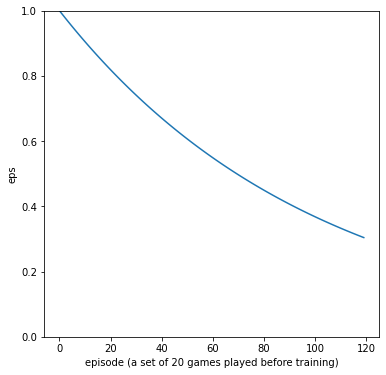

In [77]:
fig,ax = plt.subplots(figsize=(6,6))

eps_i = []
for epsisode_i in range(max_episodes):
    eps_i.append( max(eps_min, initial_eps*np.exp( - eps_delta * epsisode_i )) )
    
ax.plot(eps_i)
ax.set_ylim(0,1)
ax.set_xlabel('episode (a set of '+str(n_games_per_episode)+' games played before training)')
ax.set_ylabel('eps')
plt.show()

## fill the memory buffer with random games

only keep games that manages to randomly finish in under 1500 steps

In [78]:
collected_games = 0
while collected_games < 20:

    game_memory,steps,rewards = play_game_agent(Qnet,1,render=False)
    
    if steps < 1000:    
        mem.push(game_memory)
        collected_games+=1

## perform an initial training where we aim for the Q values to be just the immediate reward (without confusing it with the initial Q values given by the network)

if you don't understand what I mean, look at the visualisation below

In [79]:
Qnet.train()
for train_step_i in range(5000):
    opt.zero_grad()

    bs, ba, br, bns, bdone = mem.sample(batch_size)

    bq = Qnet(bs).gather(1, ba.unsqueeze(1)).squeeze(1)
    
    #normally, you would use the existing Q value given by the network to compute the next step Q value
    #but for the intiail training we assume the next Q value is 0, this helps start the training on the right foot
    #bnq = Tnet(bns).detach().max(1)[0] * gamma * (1 - bdone)
    
    loss = F.smooth_l1_loss(bq, br)
        

    loss.backward()

    opt.step()

## let's visualize the inital training to make it clear what it did:

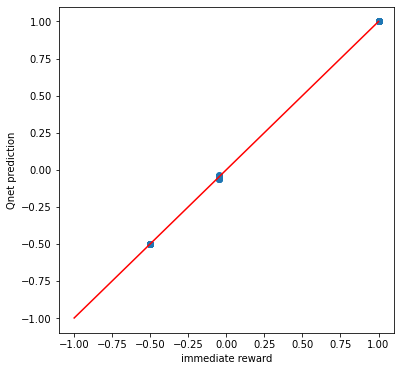

In [80]:
Qnet.eval()

batch_rewards = []
batch_qs = []

for eval_step_i in range(300):
    
    bs, ba, br, bns, bdone = mem.sample(batch_size)

    bq = Qnet(bs).gather(1, ba.unsqueeze(1)).squeeze(1)
    
    bg = list(bq.data.numpy().flatten())
    
    batch_qs+=bg
    
    br = list(br.data.numpy().flatten())
    
    batch_rewards+=br
    
    
fig,ax = plt.subplots(figsize=(6,6))

ax.scatter(batch_rewards,batch_qs)
ax.plot([-1,1],[-1,1],c='r')
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel('immediate reward')
ax.set_ylabel('Qnet prediction')

plt.show()

In [85]:
Qnet.train()


avg_game_steps_history = []


for episode_i in range(max_episodes):
    steps_per_game = []
    reward_per_game = []
    
    cur_eps = max(eps_min, initial_eps*np.exp( - eps_delta * epsisode_i ))
    
    #play X games
    for game_i in range(n_games_per_episode):
        
        game_memory,steps,rewards = play_game_agent(Qnet,cur_eps,render=False)
        
        mem.push(game_memory)
        steps_per_game.append(steps)
        reward_per_game.append(rewards)

    print('episode ',episode_i+1,' avg steps per game ',np.mean(steps_per_game), ' avg rewards '
          ,np.mean(reward_per_game) )
    
    #save the sate of the neural network at the start of the episode
    #if episode_i % 2 == 0:
    Tnet.load_state_dict(Qnet.state_dict())
    #train the network
    for train_step_i in range(n_train_steps):

        opt.zero_grad()

        bs, ba, br, bns, bdone = mem.sample(batch_size)

        bq = Qnet(bs).gather(1, ba.unsqueeze(1)).squeeze(1)
        
        bnq = Tnet(bns).detach().max(1)[0] * gamma * (1 - bdone)
        loss = F.smooth_l1_loss(bq, br + bnq)

        loss.backward()

        opt.step()
    
    

    

        
    

episode  1  avg steps per game  209.7  avg rewards  -19.2675
episode  2  avg steps per game  24.3  avg rewards  -1.1324999999999998
episode  3  avg steps per game  92.8  avg rewards  -7.640000000000008
episode  4  avg steps per game  25.9  avg rewards  -1.4599999999999995
episode  5  avg steps per game  24.4  avg rewards  -1.2274999999999998
episode  6  avg steps per game  37.8  avg rewards  -2.504999999999998
episode  7  avg steps per game  24.35  avg rewards  -1.2699999999999996
episode  8  avg steps per game  881.25  avg rewards  -83.61749999999866
episode  9  avg steps per game  24.85  avg rewards  -1.2049999999999996
episode  10  avg steps per game  74.45  avg rewards  -5.777500000000002
episode  11  avg steps per game  39.5  avg rewards  -2.2075
episode  12  avg steps per game  24.65  avg rewards  -1.1724999999999999
episode  13  avg steps per game  25.55  avg rewards  -1.2174999999999998
episode  14  avg steps per game  37.2  avg rewards  -2.429999999999998
episode  15  avg step

KeyboardInterrupt: 

## now let's watch our NN play the game (remember we gave a fixed starting condition)

In [26]:
Qnet.eval()

#eps=0 means the neural network is totally in charge
play_game_agent(Qnet,eps=0,render=True);

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
steps  16 action  5  reward  1.0
done!


In [94]:
torch.save(Qnet.state_dict(),'qnet.pt')

In [24]:
Qnet = QNet()

In [25]:
Qnet.load_state_dict(torch.load('qnet.pt'))

<All keys matched successfully>